In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

os.chdir("..")
os.makedirs("./cache", exist_ok=True)

from datasets import ImageNet_LT
from models import *
from trainer import load_clip_to_cpu

from utils.config import _C as cfg

cfg.defrost()
cfg.merge_from_file('./configs/data/imagenet_lt.yaml')
cfg.merge_from_file('./configs/model/clip_vit_b16.yaml')
cfg.mask = True
cfg.mask_ratio = "0.01"
cfg.lr = 0.01

cfg.gpu = 1
device = torch.device("cuda:{}".format(cfg.gpu))

cfg.model_dir = './output/imagenet_lt_clip_vit_b16_mask_True_mask_ratio_0.01_lr_0.01'

/home/shijx/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if cfg.backbone.startswith("CLIP"):
    mean = [0.48145466, 0.4578275, 0.40821073]
    std = [0.26862954, 0.26130258, 0.27577711]
else:
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]

transform_test = transforms.Compose([
    transforms.Resize(cfg.resolution * 8 // 7),
    transforms.CenterCrop(cfg.resolution),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset = ImageNet_LT(root=cfg.root, train=True, transform=transform_test)
num_classes = train_dataset.num_classes
cls_num_list = train_dataset.cls_num_list
test_dataset = ImageNet_LT(root=cfg.root, train=False, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

clip_model = load_clip_to_cpu(cfg.backbone, cfg.prec)
model = PeftModelFromCLIP(cfg, clip_model, num_classes)
model.to(device)
tuner = model.tuner
head = model.head

load_path = os.path.join(cfg.model_dir, "checkpoint.pth.tar")
checkpoint = torch.load(load_path, map_location=device)
tuner_dict = checkpoint["tuner"]
head_dict = checkpoint["head"]
tuner.load_state_dict(tuner_dict)
head.load_state_dict(head_dict)

<All keys matched successfully>

In [ ]:
train_features = []
train_labels = []

for batch in tqdm(train_loader, ascii=True):
    image = batch[0]
    label = batch[1]

    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        feature = model(image, use_tuner=True, return_feature=True)

    train_features.append(feature)
    train_labels.append(label)

train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

torch.save(train_features, './cache/imagenet_lt_mask_0.01_lr_0.01_train_features.pt')
torch.save(train_labels, './cache/imagenet_lt_mask_0.01_lr_0.01_train_labels.pt')

In [ ]:
test_features = []
test_labels = []

for batch in tqdm(test_loader, ascii=True):
    image = batch[0]
    label = batch[1]

    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        feature = model(image, use_tuner=True, return_feature=True)

    test_features.append(feature)
    test_labels.append(label)

test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

torch.save(test_features, './cache/imagenet_lt_mask_0.01_lr_0.01_test_features.pt')
torch.save(test_labels, './cache/imagenet_lt_mask_0.01_lr_0.01_test_labels.pt')

In [3]:
train_features = torch.load('./cache/imagenet_lt_mask_0.01_lr_0.01_train_features.pt', map_location=device)
train_labels = torch.load('./cache/imagenet_lt_mask_0.01_lr_0.01_train_labels.pt', map_location=device)

sorted_sample_idx = train_labels.argsort()
train_features = train_features[sorted_sample_idx]
train_labels = train_labels[sorted_sample_idx]

unique_labels, label_counts = torch.unique(train_labels, return_counts=True)

train_class_means = [None] * num_classes
train_class_sims = [None] * num_classes
idx = 0
for i, cnt in zip(unique_labels, label_counts):
    train_class_means[i] = train_features[idx: idx+cnt].mean(dim=0)
    train_class_sims[i] = F.normalize(train_class_means[i], dim=-1) @ F.normalize(train_features[idx: idx+cnt]).t()
    idx += cnt
train_class_means = torch.stack(train_class_means, dim=0)

In [4]:
test_features = torch.load('./cache/imagenet_lt_mask_0.01_lr_0.01_test_features.pt', map_location=device)
test_labels = torch.load('./cache/imagenet_lt_mask_0.01_lr_0.01_test_labels.pt', map_location=device)

sorted_sample_idx = test_labels.argsort()
test_features = test_features[sorted_sample_idx]
test_labels = test_labels[sorted_sample_idx]

unique_labels, label_counts = torch.unique(test_labels, return_counts=True)

test_class_means = [None] * num_classes
test_class_sims = [None] * num_classes
idx = 0
for i, cnt in zip(unique_labels, label_counts):
    test_class_means[i] = test_features[idx: idx+cnt].mean(dim=0)
    test_class_sims[i] = F.normalize(test_class_means[i], dim=-1) @ F.normalize(test_features[idx: idx+cnt]).t()
    idx += cnt
test_class_means = torch.stack(test_class_means, dim=0)

In [5]:
sorted_cls_idx = torch.tensor(cls_num_list).argsort(descending=True)

sim = F.normalize(test_class_means[sorted_cls_idx]) @ F.normalize(test_class_means[sorted_cls_idx]).t()

sim = sim.cpu()

In [6]:
colors = sns.color_palette("hls", 10)

# linewidth = 1.3
fontsize = 28

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('font', size=fontsize)

def _savefig(name='./image.jpg', dpi=300):
    plt.savefig(name, dpi=dpi, bbox_inches='tight')
    print('Image saved at {}'.format(name))

Image saved at plot/heatmap_imagenet_lt_sparse.pdf


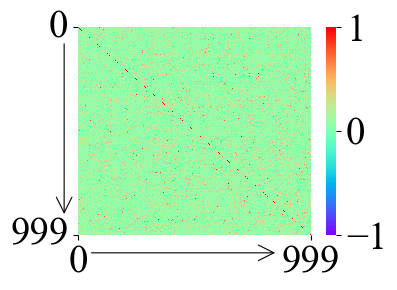

In [7]:
fig = plt.figure(figsize=(4, 3))

from matplotlib.gridspec import GridSpec

gs = GridSpec(50, 50)
ax0 = fig.add_subplot(gs[0:50, 0:50])
ax1 = fig.add_subplot(gs[0:45, 3:50])

ncls = num_classes

sns.heatmap(sim[:ncls ,:ncls], vmax=1.0, vmin=-1.0, cmap='rainbow', ax=ax1, rasterized=True)

cb = plt.gcf().axes[-1]
cb.tick_params(labelsize=fontsize)

ax1.set_xticks([0, ncls-1], [0, ncls-1], fontsize=fontsize, rotation=0)
ax1.set_yticks([0, ncls-1], [0, ncls-1], fontsize=fontsize, rotation=0)

ax0.axis('off')

ax0.set_xlim(-0.15, 10)
ax0.set_ylim(-0.25, 10)
ax0.annotate("", xy=(0, 1.6), xytext=(0, 9.4), arrowprops=dict(arrowstyle="->", linewidth=0.8))
ax0.annotate("", xy=(7.0, 0), xytext=(0.8, 0), arrowprops=dict(arrowstyle="->", linewidth=0.8))

_savefig('plot/heatmap_imagenet_lt_sparse.pdf', dpi=180)

In [8]:
is_many = torch.tensor(cls_num_list) > 100
is_few = torch.tensor(cls_num_list) < 20
is_med = ~(is_many | is_few)

train_many_sims = torch.cat([train_class_sims[i] for i in range(num_classes) if is_many[i]])
train_med_sims = torch.cat([train_class_sims[i] for i in range(num_classes) if is_med[i]])
train_few_sims = torch.cat([train_class_sims[i] for i in range(num_classes) if is_few[i]])

test_many_sims = torch.cat([test_class_sims[i] for i in range(num_classes) if is_many[i]])
test_med_sims = torch.cat([test_class_sims[i] for i in range(num_classes) if is_med[i]])
test_few_sims = torch.cat([test_class_sims[i] for i in range(num_classes) if is_few[i]])

Image saved at plot/class_scatter_imagenet_lt_sparse_head.pdf


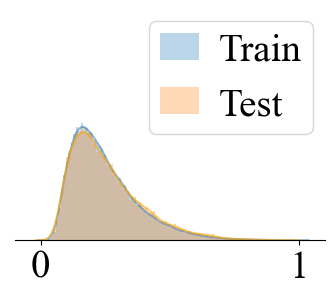

In [9]:
plt.figure(figsize=(4, 3))
sns.histplot((1 - train_many_sims).cpu(), bins=100, stat='density', edgecolor=None, alpha=0.3, label='Train', rasterized=True)
sns.histplot((1 - test_many_sims).cpu(), bins=100, stat='density', edgecolor=None, alpha=0.3, label='Test', rasterized=True)
sns.kdeplot((1 - train_many_sims).cpu(), color='steelblue', alpha=0.6)
sns.kdeplot((1 - test_many_sims).cpu(), color='orange', alpha=0.6)
plt.xticks([0, 1], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)
plt.xlim(-0.1, 1.1)
plt.ylim(0, 8)
plt.legend(fontsize=fontsize, borderpad=0.3, borderaxespad=0.3, handlelength=1.0, handletextpad=0.5)
plt.ylabel("")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
_savefig('plot/class_scatter_imagenet_lt_sparse_head.pdf')

Image saved at plot/class_scatter_imagenet_lt_sparse_tail.pdf


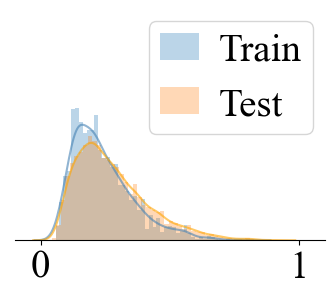

In [10]:
plt.figure(figsize=(4, 3))
sns.histplot((1 - train_few_sims).cpu(), bins=50, stat='density', edgecolor=None, alpha=0.3, label='Train', rasterized=True)
sns.histplot((1 - test_few_sims).cpu(), bins=50, stat='density', edgecolor=None, alpha=0.3, label='Test', rasterized=True)
sns.kdeplot((1 - train_few_sims).cpu(), color='steelblue', alpha=0.6)
sns.kdeplot((1 - test_few_sims).cpu(), color='orange', alpha=0.6)
plt.xticks([0, 1], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)
plt.xlim(-0.1, 1.1)
plt.ylim(0, 8)
plt.legend(fontsize=fontsize, borderpad=0.3, borderaxespad=0.3, handlelength=1.0, handletextpad=0.5)
plt.ylabel("")
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
_savefig('plot/class_scatter_imagenet_lt_sparse_tail.pdf')